# Importing the age distribution and cleaning


In [1]:
import pandas as pd
import numpy as np

age_dist = pd.read_csv('data/census/PEP_2017_PEPSYASEXN_with_ann.csv')

# Here are the labels used for the different genders
age_dist['Sex.display-label']

0           Sex
1    Both Sexes
2        Female
3          Male
Name: Sex.display-label, dtype: object

In [2]:
# This is a very messy dataset, which contains all the columns for ages from 2010 to 2017, for ages 0 to 100
# Filter down to the most recent result: 2017
filtered_column_names = [colname for colname in age_dist.columns if 'est72017_age' in colname]
column_name_map = {c:c.split('age')[1] for c in filtered_column_names}

In [3]:
age_dist2017 = age_dist[filtered_column_names].rename(columns = column_name_map)

# column 999 contains the total, drop it
age_dist2017.drop('999', axis=1, inplace=True)

# row 0 is also irrelevant, it is the description of the column
age_dist2017.drop(0, axis=0, inplace=True)

age_dist2017['gender'] = age_dist['Sex.display-label']
age_dist2017.set_index('gender', inplace=True)

In [4]:
age_dist2017_clean = age_dist2017.T.reset_index().rename(columns={'index': 'age'})

for numeric_column in ['Both Sexes', 'Female', 'Male']:
    age_dist2017_clean[numeric_column] = age_dist2017_clean[numeric_column].astype(int)
    age_dist2017_clean[numeric_column] = age_dist2017_clean[numeric_column]/age_dist2017_clean[numeric_column].sum()

In [5]:
age_dist2017_clean.head()

gender,age,Both Sexes,Female,Male
0,0,0.012094,0.011640,0.012563
1,1,0.012205,0.011757,0.012666
2,2,0.012347,0.011888,0.012821
3,3,0.012301,0.011834,0.012783
4,4,0.012268,0.011819,0.012730


In [6]:
age_dist2017_clean = age_dist2017_clean.drop('age',axis=1).reset_index().rename(columns={'index': 'age'})

In [7]:
age_dist2017_clean.head()

gender,age,Both Sexes,Female,Male
0,0,0.012094,0.011640,0.012563
1,1,0.012205,0.011757,0.012666
2,2,0.012347,0.011888,0.012821
3,3,0.012301,0.011834,0.012783
4,4,0.012268,0.011819,0.012730


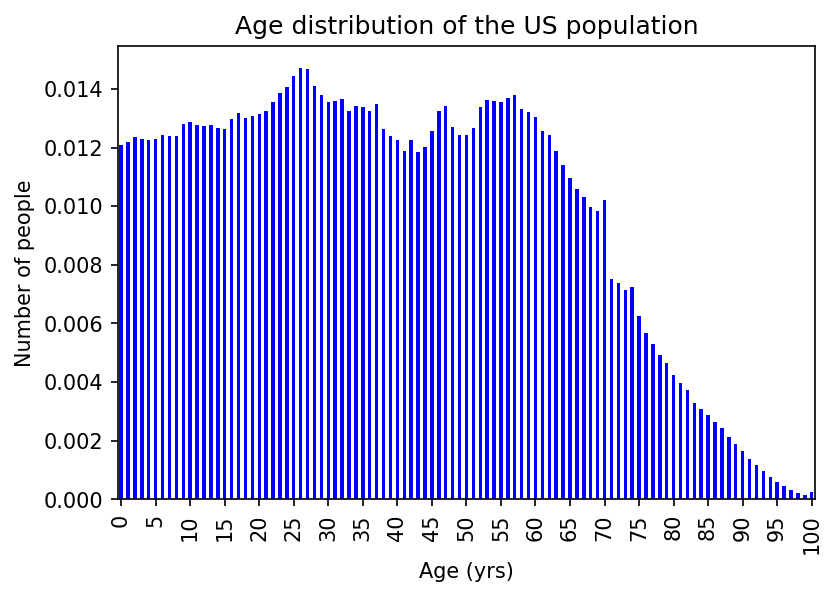

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(dpi = 150)
age_dist2017_clean['Both Sexes'].plot.bar(color='blue')
plt.xlabel('Age (yrs)')
plt.ylabel('Number of people');
plt.title('Age distribution of the US population')
plt.xticks(np.arange(0,101,5),np.arange(0,101,5));

Check that the population totals are reasonable:

In [9]:
age_dist2017_clean['Both Sexes'].sum()

1.0

## Census names

In [10]:
import glob
import re

year_extract = re.compile('\d+')

name_df_list = []
for filename in glob.glob('data/names/yob*.txt'):
    year_number = year_extract.search(filename).group(0)
    df = pd.read_csv(filename, header=None, names=['name', 'gender', 'count'])
    df['year'] = int(year_number)
    df['age'] = 2017 - int(year_number)
    name_df_list.append(df)

In [11]:
name_df = pd.concat(name_df_list)
name_df.sort_values(['year', 'gender', 'name'], inplace=True)

# now free up the memory from the entire list of dfs
del name_df_list

In [12]:
name_df['fraction'] = name_df.groupby(['gender', 'year'])['count'].transform(lambda row: row/row.sum())
name_df.head()

,name,gender,count,year,age,fraction
177,Abbie,F,71,1880,137,0.000780
737,Abby,F,6,1880,137,0.000066
491,Abigail,F,12,1880,137,0.000132
32,Ada,F,652,1880,137,0.007165
325,Adah,F,24,1880,137,0.000264


In [13]:
def filter_frame(name, gender):
    filtered = name_df[(name_df['name'] == name) & (name_df['gender'] == gender)]
    return filtered

filter_frame('Damien', 'M').head()

,name,gender,count,year,age,fraction
8084,Damien,M,6,1936,81,0.000006
8240,Damien,M,6,1938,79,0.000005
7031,Damien,M,13,1940,77,0.000011
7601,Damien,M,9,1941,76,0.000007
8370,Damien,M,7,1942,75,0.000005


In [14]:
def naive_bayes(name, gender):
    filtered = filter_frame(name, gender)
    if gender == 'M':
        population = age_dist2017_clean[['age','Male']].rename(columns={'Male': 'prior'})
    else:
        population = age_dist2017_clean[['age','Female']].rename(columns={'Female': 'prior'})
    
    merged_sets = pd.merge(filtered, population,on='age')
    merged_sets['liklihood_prior'] = merged_sets['fraction'] * merged_sets['prior']
    merged_sets['probability'] = merged_sets['liklihood_prior'] / merged_sets['liklihood_prior'].sum() 
    return merged_sets


damien = naive_bayes('Damien', 'M')

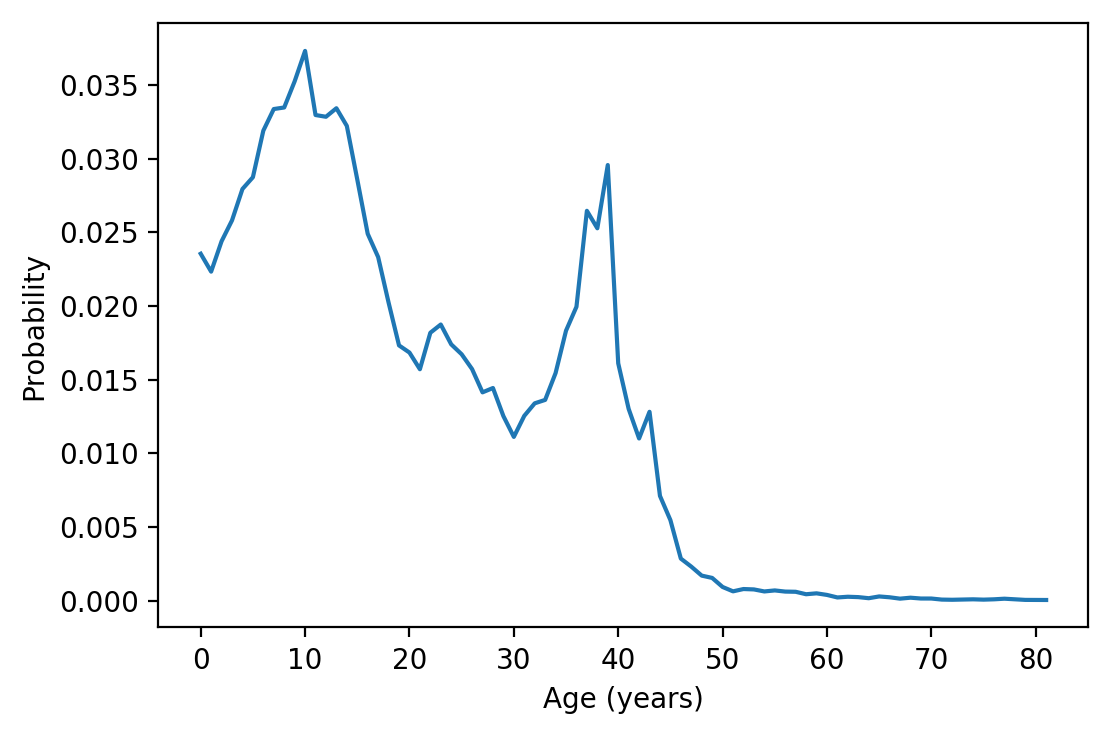

In [15]:
plt.figure(dpi=200)

plt.plot(damien['age'], damien['probability'])
plt.xlabel('Age (years)')
plt.ylabel('Probability');

In [16]:
def make_plot(name, gender):
    name_frame = naive_bayes(name, gender)
    gender_label = {'M': 'men', 'F': 'women'}
    
    plt.figure(dpi=200)
    plt.plot(name_frame['age'], name_frame['probability'])
    plt.title(f'Probability of age for {gender_label[gender]} named {name}')
    plt.xlabel('Age (years)')
    plt.ylabel('Probability');


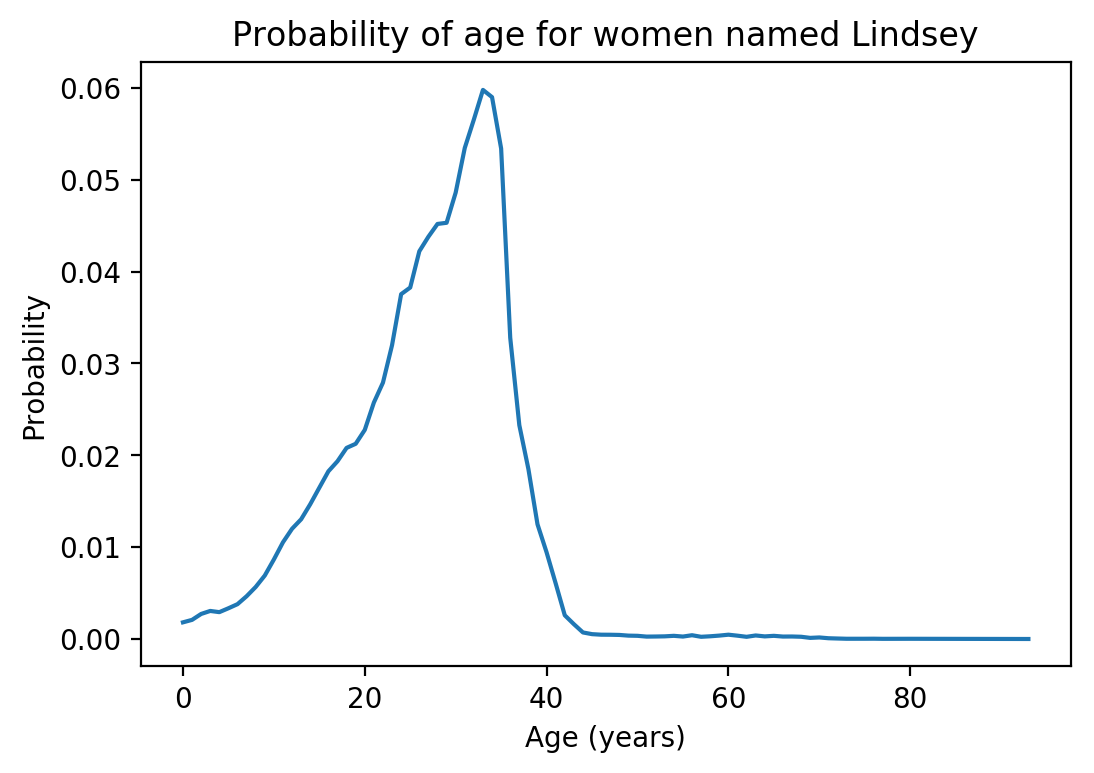

In [17]:
make_plot('Lindsey', 'F')


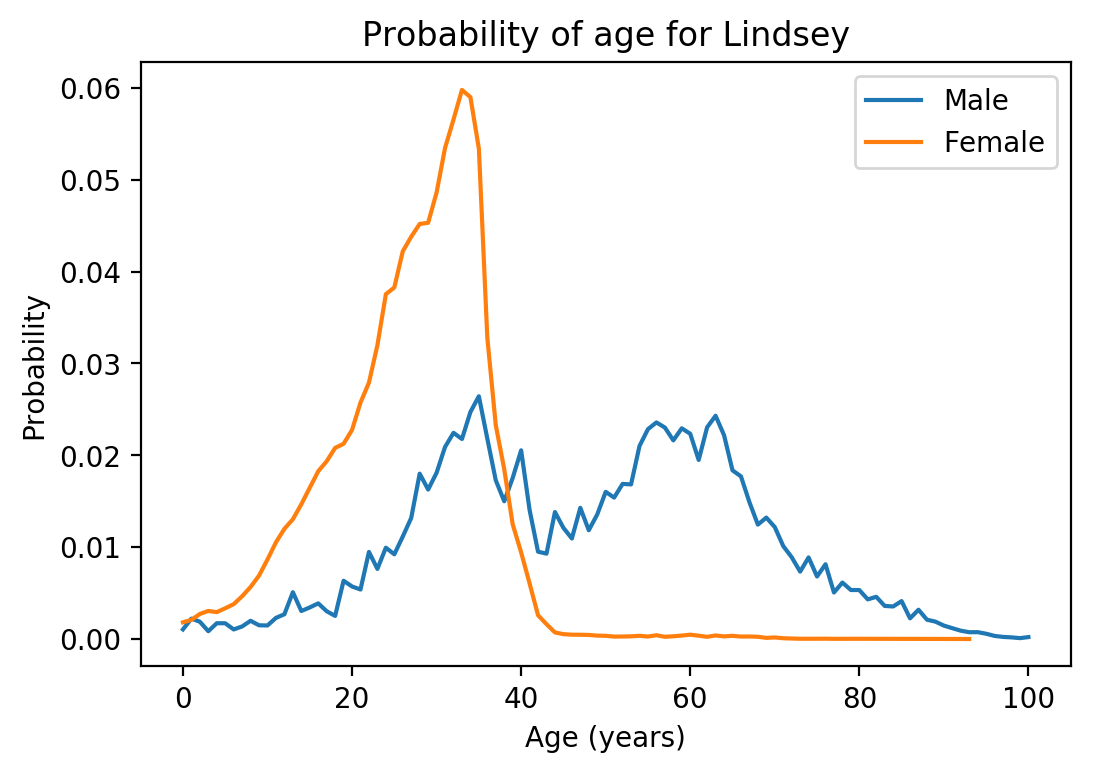

In [24]:
# Linsey is an interesting case, let's plot both on the same axis
lindsey_male = naive_bayes('Lindsey', 'M')
lindsey_female = naive_bayes('Lindsey', 'F')

plt.figure(dpi=200)
plt.plot(lindsey_male['age'], lindsey_male['probability'], label='Male')
plt.plot(lindsey_female['age'], lindsey_female['probability'], label='Female')

plt.title(f'Probability of age for Lindsey')
plt.xlabel('Age (years)')
plt.ylabel('Probability')
plt.legend();

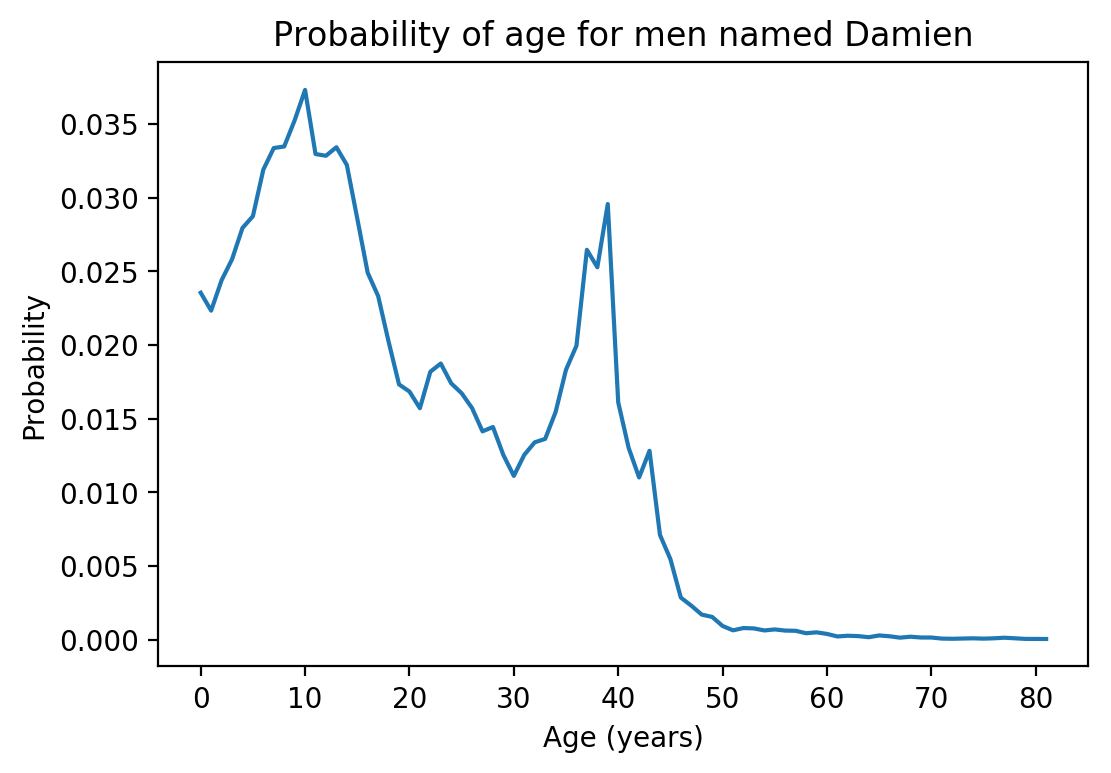

In [19]:
make_plot('Damien', 'M')

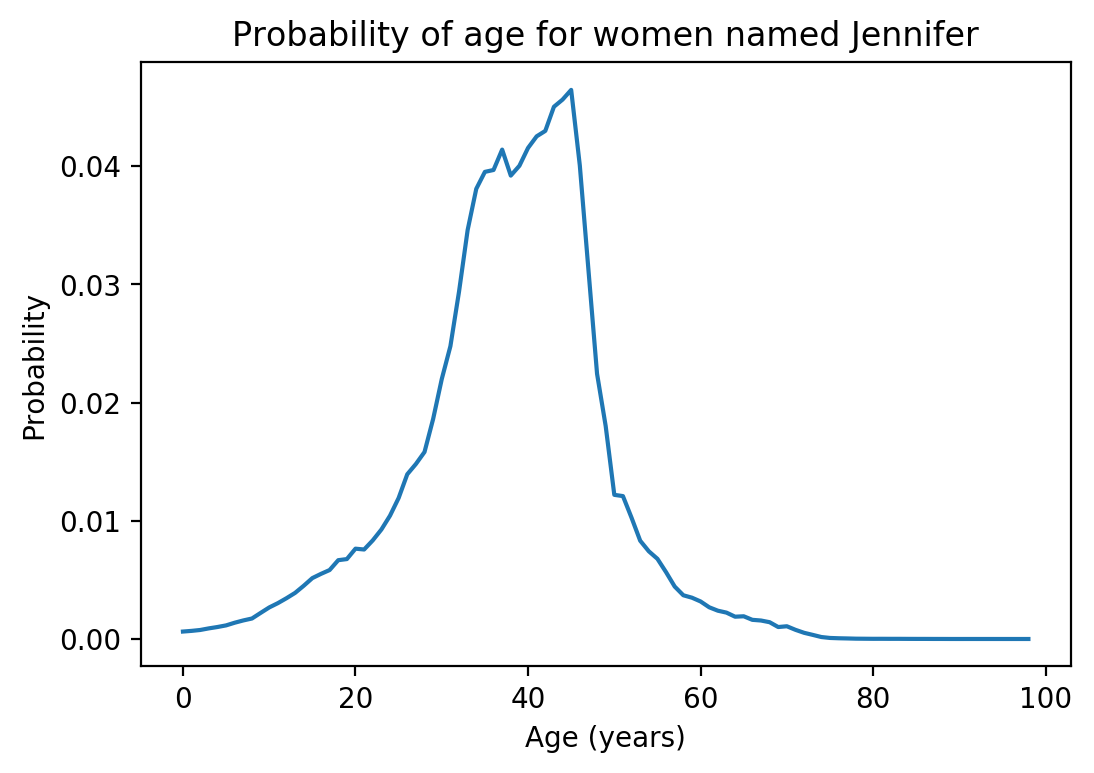

In [20]:
make_plot('Jennifer', 'F')

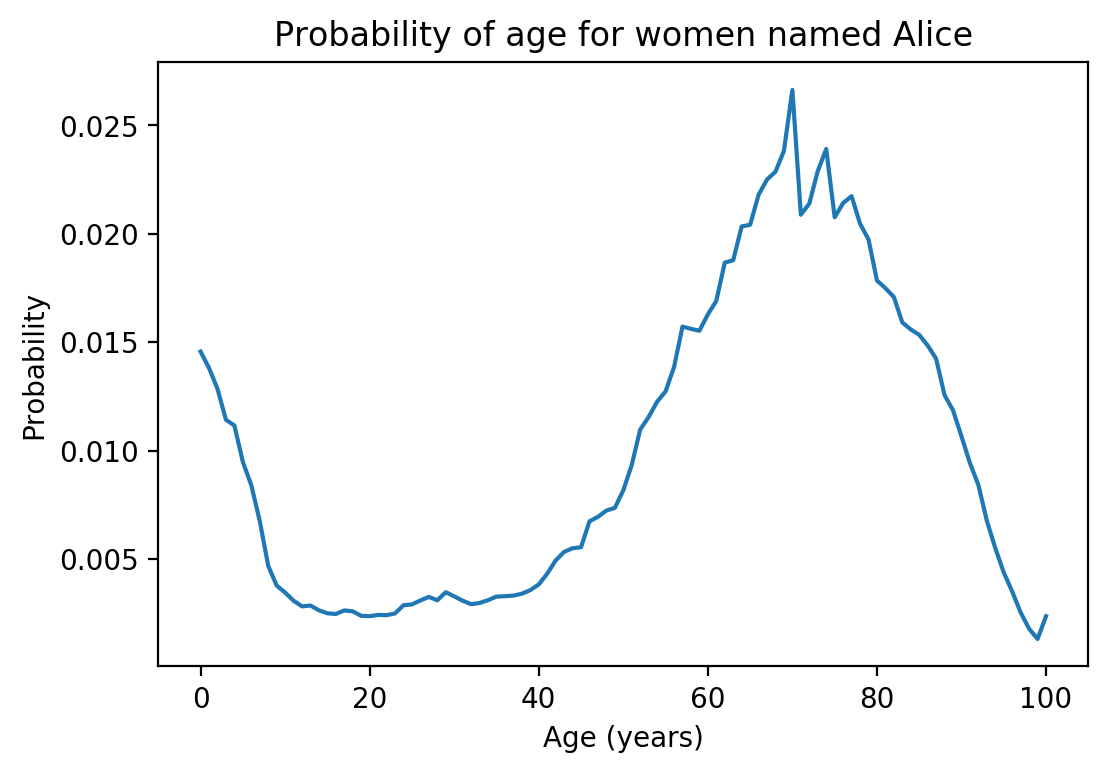

In [21]:
make_plot('Alice', 'F')

## Age quartiles

In [42]:
long_age_dist2017 = (age_dist2017_clean
                         .rename(columns={'Male': 'M', 'Female': 'F'})
                         .melt(id_vars=['age'], value_vars=['F', 'M'], value_name='gender_age_prior')
                    )

In [43]:
long_age_dist2017.head()

,age,gender,gender_age_prior
0,0,F,0.011640
1,1,F,0.011757
2,2,F,0.011888
3,3,F,0.011834
4,4,F,0.011819


In [45]:
names_and_ages = pd.merge(name_df, long_age_dist2017)
names_and_ages.head()

,name,gender,count,year,age,fraction,gender_age_prior
0,Aaron,F,5,1917,100,0.000005,0.000413
1,Abbey,F,8,1917,100,0.000007,0.000413
2,Abbie,F,136,1917,100,0.000126,0.000413
3,Abby,F,11,1917,100,0.000010,0.000413
4,Abell,F,5,1917,100,0.000005,0.000413


In [49]:
names_and_ages['liklihood_prior'] = names_and_ages['fraction'] * names_and_ages['gender_age_prior']
names_and_ages['probability'] = names_and_ages.groupby(['name', 'gender'])['liklihood_prior'].transform(lambda row: row/row.sum())
names_and_ages.head()

,name,gender,count,year,age,fraction,gender_age_prior,liklihood_prior,probability
0,Aaron,F,5,1917,100,0.000005,0.000413,1.912023e-09,0.000060
1,Abbey,F,8,1917,100,0.000007,0.000413,3.059236e-09,0.000025
2,Abbie,F,136,1917,100,0.000126,0.000413,5.200702e-08,0.000456
3,Abby,F,11,1917,100,0.000010,0.000413,4.206450e-09,0.000010
4,Abell,F,5,1917,100,0.000005,0.000413,1.912023e-09,1.000000


In [51]:
names_and_ages[(names_and_ages['name'] == 'Damien') & (names_and_ages['gender'] == 'M')]['probability'].sum()

0.9999999999999999

In [54]:
#names_and_ages[(names_and_ages['name'] == 'Damien') & (names_and_ages['gender'] == 'M')].cumsum()
names_and_ages['percentile'] = names_and_ages.groupby(['name', 'gender'])['probability'].cumsum()

In [85]:
names_and_ages[(names_and_ages['name'] == 'Damien') & (names_and_ages['gender'] == 'M')].head()

,name,gender,count,year,age,fraction,gender_age_prior,liklihood_prior,probability,percentile
197475,Damien,M,6,1936,81,0.000006,0.003442,1.991419e-08,0.000051,0.000051
215426,Damien,M,6,1938,79,0.000005,0.004144,2.242244e-08,0.000058,0.000109
233399,Damien,M,13,1940,77,0.000011,0.004798,5.381595e-08,0.000138,0.000247
242440,Damien,M,9,1941,76,0.000007,0.005158,3.780274e-08,0.000097,0.000344
251816,Damien,M,7,1942,75,0.000005,0.005760,2.919898e-08,0.000075,0.000419


There are quite a few "small" samples in this dataset. For example, there are a few males named Jennifer, which are preseumably typographical errors. We will count how popular a name / gender combo is, and eliminate those without enough support

In [88]:
names_and_ages['support'] = names_and_ages.groupby(['name', 'gender'])['count'].transform(sum)

In [93]:
names_and_ages.head()

,name,gender,count,year,age,fraction,gender_age_prior,liklihood_prior,probability,percentile,support
0,Aaron,F,5,1917,100,0.000005,0.000413,1.912023e-09,0.000060,0.000060,4282
1,Abbey,F,8,1917,100,0.000007,0.000413,3.059236e-09,0.000025,0.000025,17139
2,Abbie,F,136,1917,100,0.000126,0.000413,5.200702e-08,0.000456,0.000456,17767
3,Abby,F,11,1917,100,0.000010,0.000413,4.206450e-09,0.000010,0.000010,57329
4,Abell,F,5,1917,100,0.000005,0.000413,1.912023e-09,1.000000,1.000000,5


In [94]:
min_support = 5000

names_and_ages = names_and_ages[names_and_ages['support'] > min_support]

In [95]:
def get_percentile(percentile):
 return names_and_ages.groupby(['name', 'gender']).apply(lambda x: x.loc[abs(x['percentile'] - percentile).idxmin(), 'age'])

In [96]:
percentiles = [get_percentile(0.25), get_percentile(0.5), get_percentile(0.75)]

In [100]:
percentile_frame = pd.concat(percentiles, axis=1).rename(columns={0: '0.75', 1: '0.5', 2:'0.25'})
del percentiles

In [101]:
percentile_frame.loc[('Damien',), :]

,0.75,0.5,0.25
gender,,,
M,32,17,9


In [102]:
percentile_frame.loc[('Violet', ), :]

,0.75,0.5,0.25
gender,,,
F,70,10,4


In [104]:
percentile_frame.loc[('Lula', ), :]

,0.75,0.5,0.25
gender,,,
F,84,75,65


In [107]:
percentile_frame['0.75'].sort_values(ascending=False)

name      gender
Lucile    F         89
Gertrude  F         89
Seymour   M         88
Imogene   F         88
Berniece  F         88
Myrtle    F         87
Florence  F         87
Madge     F         87
Opal      F         87
Nannie    F         87
Muriel    F         87
Beulah    F         87
Mildred   F         87
Blanche   F         87
Thelma    F         86
Leota     F         86
Bertie    F         86
Flossie   F         86
Mabel     F         86
Maude     F         86
Dorris    F         86
Iola      F         86
Dortha    F         86
Agnes     F         86
Eleanore  F         86
Gussie    F         85
Ima       F         85
Erna      F         85
Syble     F         85
Gladys    F         85
                    ..
Blakely   F          6
Zaiden    M          6
Paisley   F          6
Isla      F          6
Legend    M          6
Brantley  M          6
Harlow    F          6
Journee   F          6
Jaxton    M          6
Mila      F          6
Knox      M          6
Emersyn   F      